We start by importing our basic libraries.

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

2025-09-27 19:28:10.863167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759001291.029986      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759001291.079501      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Then, we analyze general information about our data set; how many images there are in total and how they are distributed across classes.

In [2]:
data="/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]"
counts=[]
folders = os.listdir(data)
print("The folders in this data set:",folders)

for folder in folders:
    count=len(os.listdir(os.path.join(data,folder)))
    counts.append(count)
    print(f"\n There are {count} images in this {folder}.")
print(f"\n There are {sum(counts)} images in Blood Cell Cancer data set.")

The folders in this data set: ['[Malignant] early Pre-B', '[Malignant] Pro-B', '[Malignant] Pre-B', 'Benign']

 There are 979 images in this [Malignant] early Pre-B.

 There are 796 images in this [Malignant] Pro-B.

 There are 955 images in this [Malignant] Pre-B.

 There are 512 images in this Benign.

 There are 3242 images in Blood Cell Cancer data set.


We then convert this information into a bar chart.

<function matplotlib.pyplot.show(close=None, block=None)>

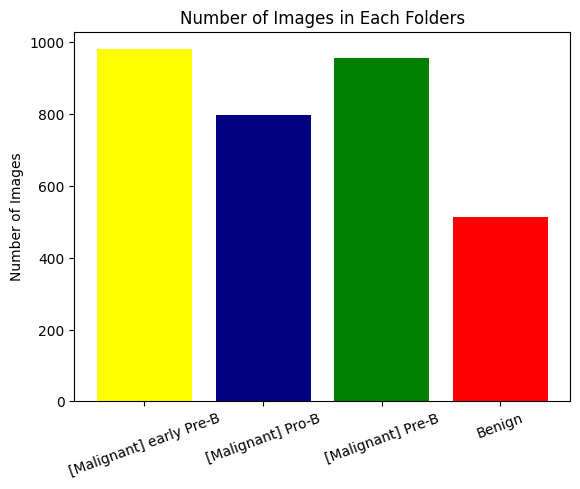

In [3]:
plt.bar(folders,counts, color=["yellow","navy","green","red"])
plt.title("Number of Images in Each Folders")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.show

To work more effectively with the data we are examining, we are getting one sample image from each data folder.

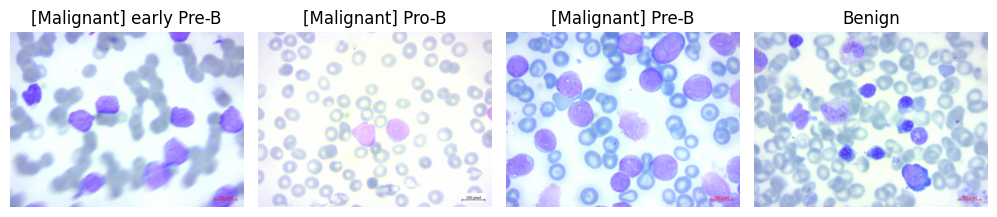

In [4]:
plt.figure(figsize=(20,10))

for i, f in enumerate(folders):
    img_file = random.choice(os.listdir(os.path.join(data, f)))
    img_path = os.path.join(data, f, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(5,8,i+1)
    plt.imshow(img)
    plt.title(f)
    plt.axis("off")
plt.tight_layout()
plt.show()

We are adding features such as rotation, shift, and zoom here to enable our model to achive better results.(The purpose is to enable it to analyze an image better and make the most accurate selection.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=(150,150)
batch_size=32
image_gen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
    
)

train_gen=image_gen.flow_from_directory(
    "/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

validation_gen=image_gen.flow_from_directory(
    "/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 2595 images belonging to 4 classes.
Found 647 images belonging to 4 classes.


Now, let's visualize and examine our data augmentation settings in an example.

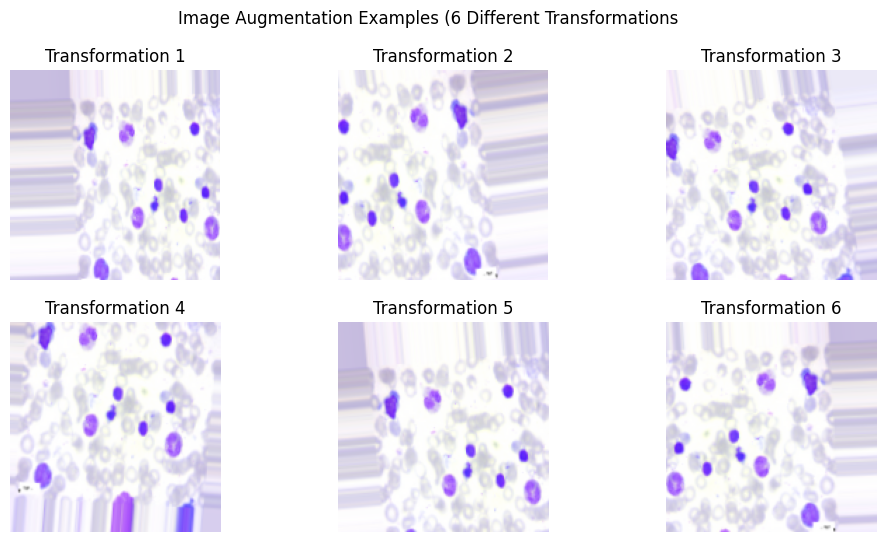

In [6]:
x_batch,y_batch =next(train_gen)
sample_img = x_batch[0]

plt.figure(figsize=(12,6))
plt.suptitle("Image Augmentation Examples (6 Different Transformations")

for i in range (6):
    augmented_img=image_gen.random_transform(sample_img)
    plt.subplot(2,3,i+1)
    plt.imshow(augmented_img)
    plt.title(f"Transformation {i+1}")
    plt.axis("off")
plt.show()
    

In [7]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

img_height, img_width=150,150
dropout_rate=0.4
learning_rate=0.001
num_clss=4

model=models.Sequential([
    layers.Conv2D(32,(3,3),input_shape=(img_height, img_width,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
  
    layers.Conv2D(64,(3,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128,(3,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(128,activation="relu"),
    layers.Dropout(dropout_rate),

    layers.Dense(64,activation="relu"),
    layers.Dropout(dropout_rate),

    layers.Dense(num_clss, activation="softmax")                    
])

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

early_stop=EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history=model.fit(
    train_gen,
    validation_data=validation_gen,
    epochs=25,
    callbacks=[early_stop]
)

I0000 00:00:1759001315.646596      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759001315.647324      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,837,764 (18.45 MB)

 Trainable params: 4,837,316 (18.45 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25


I0000 00:00:1759001322.848663     117 service.cc:148] XLA service 0x7f21840129b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759001322.849412     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759001322.849432     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759001323.432604     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/82 ━━━━━━━━━━━━━━━━━━━━ 13:52 10s/step - accuracy: 0.3125 - loss: 2.5272

I0000 00:00:1759001328.423690     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4760 - loss: 4.9525 - val_accuracy: 0.2457 - val_loss: 3.7173
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 591ms/step - accuracy: 0.7367 - loss: 0.8284 - val_accuracy: 0.2457 - val_loss: 6.3803
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 581ms/step - accuracy: 0.7640 - loss: 0.7265 - val_accuracy: 0.2457 - val_loss: 3.7553
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 590ms/step - accuracy: 0.7563 - loss: 0.7311 - val_accuracy: 0.2457 - val_loss: 6.1982
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 588ms/step - accuracy: 0.7540 - loss: 0.6772 - val_accuracy: 0.5209 - val_loss: 1.3013
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 584ms/step - accuracy: 0.7049 - loss: 0.7625 - val_accuracy: 0.4374 - val_loss: 2.2366
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 622ms/step - accuracy: 0.7591 - loss: 0.6545 - val_accuracy: 0.2488 - val_loss: 11.3975
Epoch 8/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 602ms/step - accuracy: 0.7540 - loss: 0.6390 - val_accuracy: 0.4776 

Let's transfer the Accuracy-Loss values obtained from our model to a line graph.

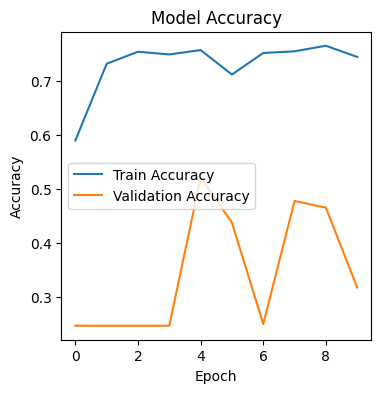

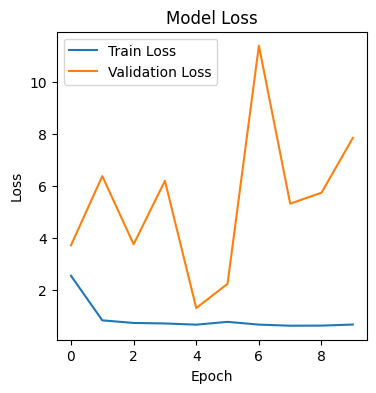

In [8]:
plt.figure(figsize=(4,4))
plt.plot(history.history["accuracy"],label="Train Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(4,4))
plt.plot(history.history["loss"],label="Train Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Our first experiment clearly demonstrated the model's tendency to overfit.

While Train Accuracy rapidly increased to over 75%, Validation Accuracy remained at around 30-40
% and did not improve. This proves that the model successfully memorized the training data but failed to generalize to new images.

The Validation Loss value rapidly increased as Epochs progressed clearly revealing the severity of the overfitting problem. This dramatic increase was the basis for our transition to Dropout and Learning Rate optimizations.

In [11]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

img_height, img_width=150,150
dropout_rate=0.4
learning_rate=0.00001
num_clss=4

model=models.Sequential([
    layers.Conv2D(32,(3,3),input_shape=(img_height, img_width,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
  
    layers.Conv2D(64,(3,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128,(3,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(128,activation="relu"),
    layers.Dropout(dropout_rate),

    layers.Dense(64,activation="relu"),
    layers.Dropout(dropout_rate),

    layers.Dense(num_clss, activation="softmax")                    
])

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

early_stop=EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history=model.fit(
    train_gen,
    validation_data=validation_gen,
    epochs=25,
    callbacks=[early_stop]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,837,764 (18.45 MB)

 Trainable params: 4,837,316 (18.45 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 59s 641ms/step - accuracy: 0.3906 - loss: 1.5712 - val_accuracy: 0.2457 - val_loss: 1.4434
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 585ms/step - accuracy: 0.5616 - loss: 1.0294 - val_accuracy: 0.2457 - val_loss: 1.7361
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 587ms/step - accuracy: 0.6296 - loss: 0.8770 - val_accuracy: 0.2457 - val_loss: 1.8702
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 596ms/step - accuracy: 0.6799 - loss: 0.8206 - val_accuracy: 0.2488 - val_loss: 1.9364
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 582ms/step - accuracy: 0.7206 - loss: 0.7185 - val_accuracy: 0.4544 - val_loss: 1.6024
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 590ms/step - accuracy: 0.7319 - loss: 0.6876 - val_accuracy: 0.5533 - val_loss: 1.3085
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 596ms/step - accuracy: 0.7337 - loss: 0.6894 - val_accuracy: 0.6491 - val_loss: 1.0493
Epoch 8/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 663ms/step - accuracy: 0.7490 - loss: 0.6560 - val_accu

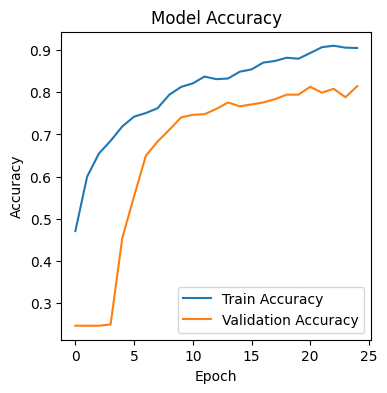

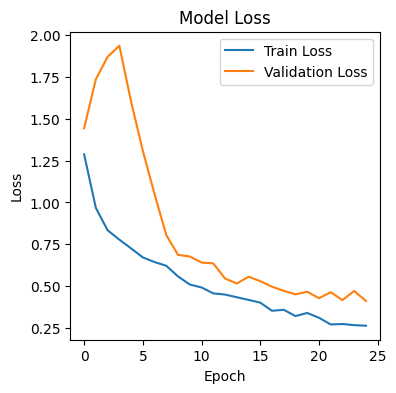

In [12]:
plt.figure(figsize=(4,4))
plt.plot(history.history["accuracy"],label="Train Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(4,4))
plt.plot(history.history["loss"],label="Train Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Our initial analysis confirmed the need for significant adjustments. To address the overfitting issue, we implemented the following fundamental corrective actions:

Learning Rate: Gradually reduced from 0.001 to 0.00001.

These corrective actions successfully stabilized the training process and produced our final, robust model. Unlike the initial attempts, Train Accuracy (91.50%) and Validation Accuracy (81.45%) now increased together. This proved that the model learned to generalize rather than memorize. The Validation Loss value also showed stability, successfully converging to a low value of 0.4111.

This optimized model represents the project's most stable and highest-performing classifier, achieved with 81.45% accuracy by effectively controlling overfitting.

Translated with DeepL.com (free version)

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step


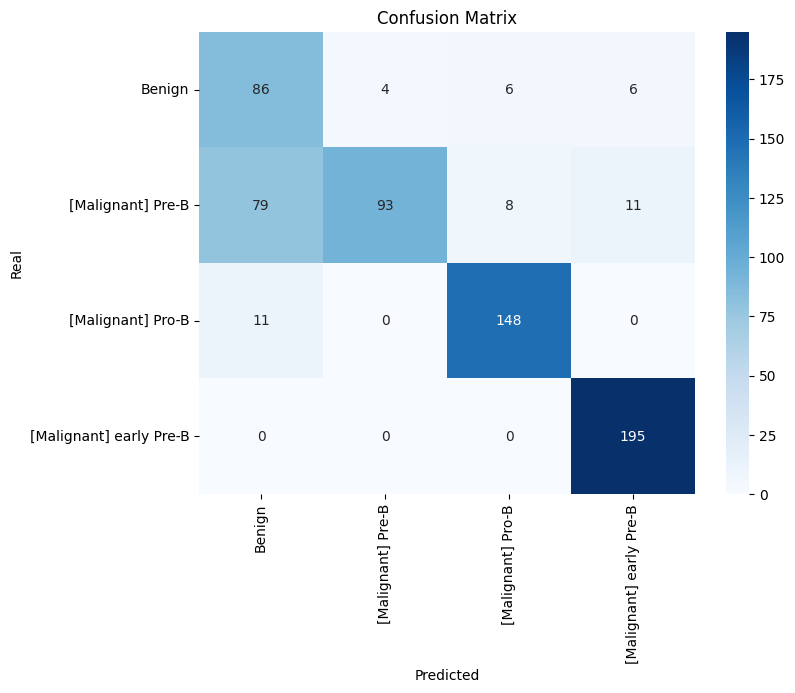

Classification Report:

                         precision    recall  f1-score   support

                 Benign       0.49      0.84      0.62       102
      [Malignant] Pre-B       0.96      0.49      0.65       191
      [Malignant] Pro-B       0.91      0.93      0.92       159
[Malignant] early Pre-B       0.92      1.00      0.96       195

               accuracy                           0.81       647
              macro avg       0.82      0.82      0.79       647
           weighted avg       0.86      0.81      0.80       647



In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

val_preds = model.predict(validation_gen)
y_pred = val_preds.argmax(axis=1)
y_true = validation_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=validation_gen.class_indices.keys(),
            yticklabels=validation_gen.class_indices.keys())

plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=validation_gen.class_indices.keys()))

Our confusion matrix demonstrates that our model largely produces accurate results. However, it clearly shows that the Malignant Pre-B and Benign classes are most frequently confused with each other.